# GAM-based Pseudotime Testing

This notebook focuses on detecting genes whose expression changes significantly along pseudotime in single-cell RNA-seq data. To achieve this, we apply **Negative Binomial Generalized Additive Models (NB-GAMs)**, which are well-suited for modeling overdispersed count data and flexible nonlinear trends.

The workflow includes three steps, namely:
- Preprocessing: Single-cell expression data with an associated pseudotime trajectory.
- Modeling: Fitting NB-GAMs to capture smooth gene expression dynamics along pseudotime.
- Testing: Evaluating whether the smooth terms significantly deviate from zero, indicating dynamic regulation.


## Load libraries

In [1]:
import mssm as ms
import gamache as gm
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

## Load data

In [38]:
adata = sc.datasets.paul15()

In [39]:
adata.layers["counts"] = adata.X.copy()
adata.raw = adata.copy()

## Preprocessing

In [40]:
sc.pp.recipe_zheng17(adata)

/Users/adaml9/Code/github/gamache/.venv/lib/python3.13/site-packages/scanpy/preprocessing/_recipes.py:185: FutureWarning: Use sc.pp.highly_variable_genes instead
  filter_result = filter_genes_dispersion(


In [41]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.umap(adata)

/Users/adaml9/Code/github/gamache/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


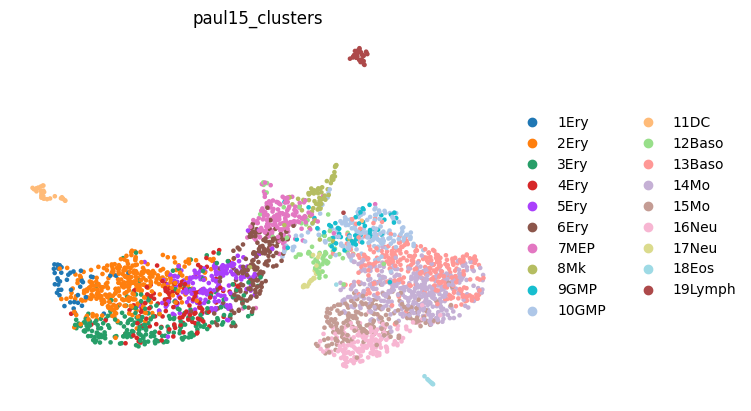

In [42]:
sc.pl.umap(adata, color=["paul15_clusters"], frameon=False)

In [43]:
# Subset to [1Ery, 2Ery, 3Ery, 4Ery, 5Ery, 6Ery, 7MEP, 8Mk]
adata = adata[
    adata.obs["paul15_clusters"].isin(
        ["1Ery", "2Ery", "3Ery", "4Ery", "5Ery", "6Ery", "7MEP", "8Mk"]
    ),
    :,
]

In [44]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.umap(adata)

/Users/adaml9/Code/github/gamache/.venv/lib/python3.13/site-packages/scanpy/preprocessing/_pca/__init__.py:385: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


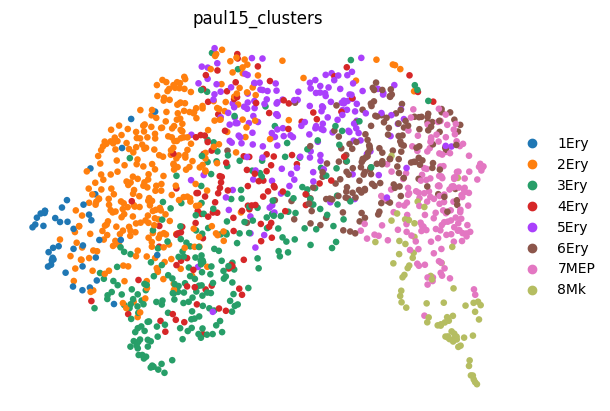

In [45]:
sc.pl.umap(adata, color=["paul15_clusters"], frameon=False)

In [46]:
sc.tl.diffmap(adata)

In [47]:
DC1 = [first[0] for first in adata.obsm["X_diffmap"]]
DC2 = [first[1] for first in adata.obsm["X_diffmap"]]
DC_tmp = [first[0] + first[1] for first in adata.obsm["X_diffmap"]]

adata.uns["iroot"] = np.argsort(DC_tmp)[-1]

sc.tl.dpt(adata)

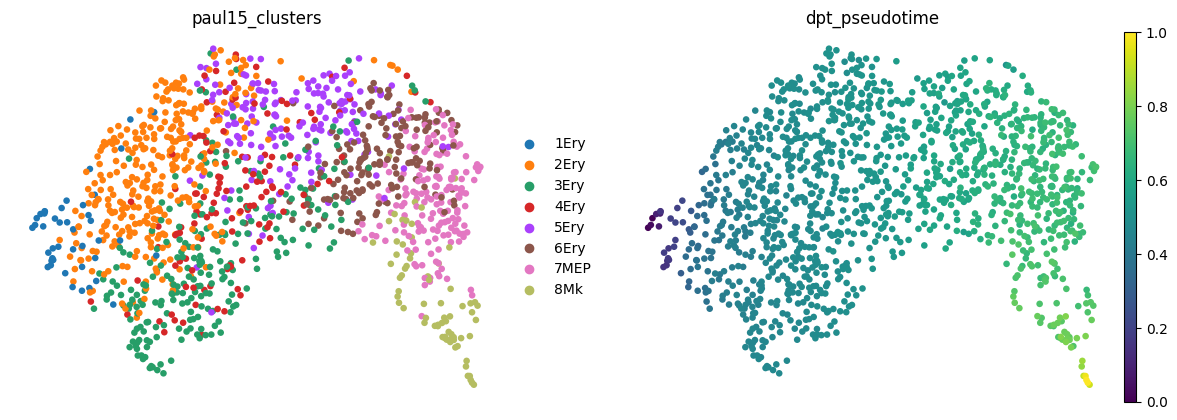

In [48]:
sc.pl.umap(adata, color=["paul15_clusters", "dpt_pseudotime"], frameon=False)

In [49]:
adata.write("paul15_endo.h5ad")

## Exclude lowly expressed genes

In [13]:
import mssm as ms
import gamache as gm
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
adata = sc.read("paul15_endo.h5ad")

# adata.X must contain raw counts for GAM fitting
adata = adata.raw.to_adata()

In [15]:
sc.pp.filter_genes(adata, min_cells=50)

## Fit the GAM model

We now fit a **Generalized Additive Model (GAM)** to the data.  
The hyperparameters can be tuned to improve the fit:

- **`lam`**: Regularization parameter that controls the amount of smoothing.  
  - Higher `lam` → smoother curve (less flexible).  
  - Lower `lam` → more flexible curve (risk of overfitting).

- **`df`**: Degrees of freedom, i.e. the number of basis functions.  
  - Higher `df` → more flexible fit.  
  - Lower `df` → smoother fit.

- **`degree`**: Polynomial degree of the spline basis functions.
  - Higher `degree` → spline pieces bend more sharply.
  - Lower `degree` → spline pieces are simpler and less wiggly. 

The choice of `lam` and `df` depends on the data and the desired balance between smoothness and flexibility.  
As a starting point, we use:

- `lam = 0.01`  
- `df = 6`
- `degree = 3`

You are strongly encouraged to experiment with different values for `lam` and `df` for your dataset.

In [16]:
adata = adata[:, ["Sphk1"]]

In [17]:
model = gm.tl.fit_gam(adata, lam=0.01, df=6, degree=3)

/Users/adaml9/Code/github/gamache/src/gamache/tl/fit.py:107: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.adata.uns[self.key] = {


(<Figure size 913x480 with 1 Axes>,
 <Axes: title={'center': 'Fit for Sphk1'}, xlabel='Pseudotime', ylabel='Expression Sphk1'>)

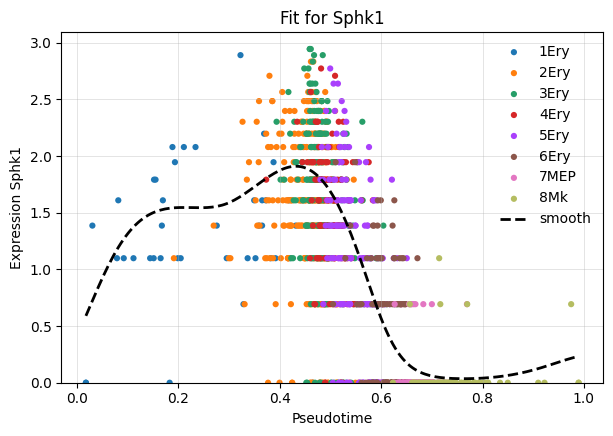

In [19]:
gm.pl.plot_gene_fit(model, adata.var_names[0], color="paul15_clusters", scatter_size=80)

## Assess Goodness of Fit

To measure how well the NB-GAM describes expression dynamics along pseudotime,  
we use the **proportion of deviance explained**.

- The **null model** assumes constant expression (a flat curve).  
- The **fitted model** explains variation by smoothing expression along pseudotime.  
- The metric is defined as:

$$D_{explained} = 1 - \frac{Deviance_{residual}}{Deviance_{null}}$$

Values range between 0 and 1:
- **0** → no improvement over the null model.  
- **1** → perfect fit to the data.  

If the deviance explained is **slightly negative**, it means the model fit is worse than the null, usually due to numerical noise or lack of signal.  
In practice, such values are often set to **0** and interpreted as “no improvement”.

In [9]:
# Get the deviance explained
gof_df = model.deviance_explained()
# Restrict to genes above zero
#gof_df = gof_df[gof_df > 0]

In [10]:
gof_df

gene
0610007L01Rik   NaN
0610009O20Rik   NaN
0610010K14Rik   NaN
0910001L09Rik   NaN
1110002B05Rik   NaN
1110004E09Rik   NaN
1110007A13Rik   NaN
1110007C09Rik   NaN
1110013L07Rik   NaN
1110020G09Rik   NaN
Name: deviance_explained, dtype: float64

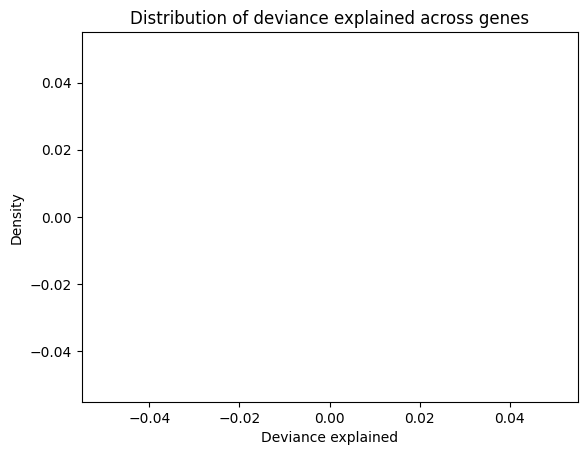

In [7]:
# Plot as a histogram
sns.histplot(gof_df, bins=50, kde=True)

plt.xlabel("Deviance explained")
plt.ylabel("Density")
plt.title("Distribution of deviance explained across genes")
plt.show()

## Test for association with pseudotime

In [55]:
# Test all genes for association with pseudotime
results_df = model.test_all(test="association")

# Filter results to significant genes
results_df = results_df[results_df["qvalue"] < 0.05]

# Set gene as index
results_df = results_df.set_index("gene")

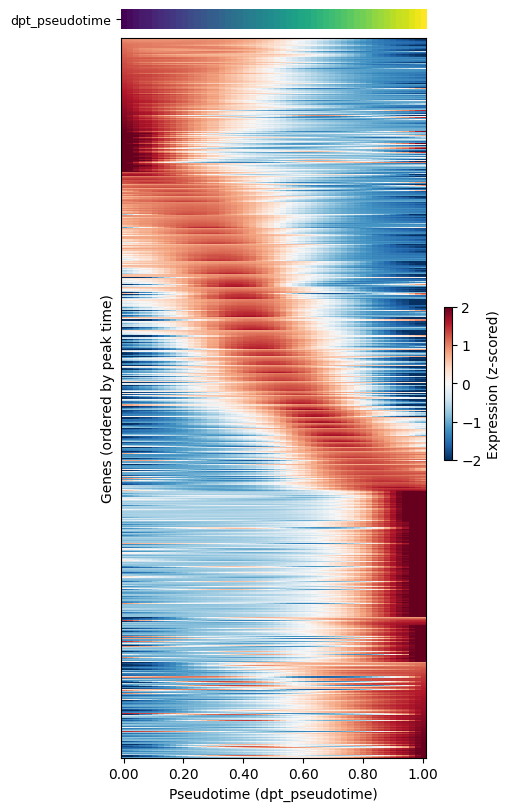

In [56]:
gm.pl.plot_gene_heatmap(adata, list(results_df.index), cmap="RdBu_r", show_gene_labels=None, model=model, figsize=(5,8))

In [57]:
# Obtain significant genes with good model fit
results_df.join(gof_df, on="gene", how="left").sort_values("deviance_explained", ascending=False).head()

,statistic,pvalue,qvalue,n_detected,edf,alpha,center_of_mass,t_peak,mean_fitted,deviance_explained
gene,,,,,,,,,,
Sphk1,395.310958,0.0,1.910794e-03,873,2.449860,1.0,0.342265,0.359614,1.895085,0.554735
Mt1,2159.218764,0.0,0.000000e+00,1109,2.727163,1.0,0.454935,0.530549,3.163601,0.527371
Mybbp1a,1949.817168,0.0,1.979675e-16,1100,3.186743,1.0,0.561210,0.550085,2.699501,0.515939
Mt2,1384.680936,0.0,0.000000e+00,983,2.470373,1.0,0.397536,0.452407,2.727988,0.515854
Eif4g1,744.013097,0.0,0.000000e+00,1032,3.128195,1.0,0.506754,0.442640,2.372427,0.491812


(<Figure size 913x480 with 1 Axes>,
 <Axes: title={'center': 'Fit for Sphk1'}, xlabel='Pseudotime', ylabel='Expression Sphk1'>)

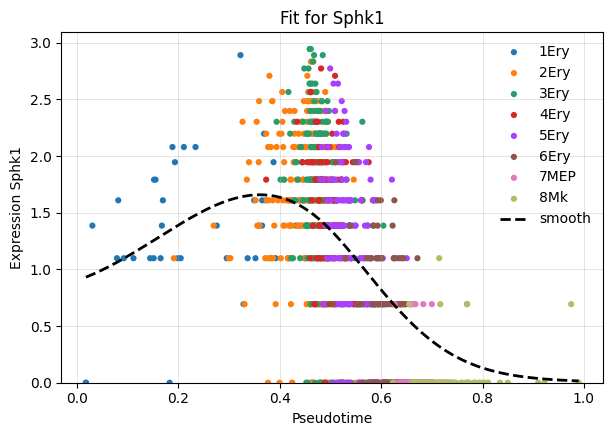

In [58]:
gm.pl.plot_gene_fit(model, "Sphk1", color="paul15_clusters", scatter_size=80)